## Attribution

This section covers more details on attributions using the fitted model object:

1. meaning of the output dataframes
2. what-if scenario generation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from karpiu.models import MMM
from karpiu.explainability import Attributor, AttributorLegacy

pd.set_option("display.float_format", lambda x: "%.5f" % x)
np.set_printoptions(suppress=True)
pd.set_option("display.max_rows", 50)

In [2]:
%load_ext autoreload
%autoreload 2

### Data and Model

To star with, we need a fitted MMM and we can reuse the one we fitted from the previous `Quickstart` section.

In [3]:
with open("./resource/model.pkl", "rb") as f:
    mmm = pickle.load(f)

After that, users need to specify the interval for the attribution period.

### Attribution on Historic Performance

In [4]:
ATTR_START = "2020-01-01"
ATTR_END = "2020-03-31"

spend_cols = mmm.get_spend_cols()
channels = ["organic"] + spend_cols

In [5]:
mmm.get_regression_summary()

,regressor,sign,coef_p50,coef_p05,coef_p95,Pr(coef >= 0),Pr(coef < 0),loc_prior,scale_prior
0,promo,Positive,0.05736,0.04121,0.07378,1.00000,0.00000,0.00000,0.10000
1,radio,Positive,0.05506,0.03968,0.06886,1.00000,0.00000,0.00000,0.10000
2,search,Positive,0.20909,0.18660,0.23081,1.00000,0.00000,0.00000,0.10000
3,social,Positive,0.07827,0.05903,0.09767,1.00000,0.00000,0.00000,0.10000
4,tv,Positive,0.10681,0.08683,0.12805,1.00000,0.00000,0.00000,0.10000


 Then users can utilize `Attributor.make_attribution()` to derive attribution summary. There are four output dataframes here:

 1. `activities_attr_df`: attribution against sales date
 2. `spend_attr_df`: attribution against spend date
 3. `spend_df`: spend against spend date (original input)
 4. `cost_df`: cost per sales against spend date (output item 3 divided by output item 2)

 The difference between output item 1 and output item 2 is that item 1 describes attribution against the date the sales actually happened while item 2 is from the accounting prospective -- it describes the attribution against the date when the spend tied to such attribution happened.

 In the case where there is no adstock in the model, one should expect these two output items are identical.

In [6]:
attr_obj = Attributor(mmm, attr_regressors=channels, start=ATTR_START, end=ATTR_END)
activities_attr_df, spend_attr_df, spend_df, cost_df = attr_obj.make_attribution(
    debug=True
)

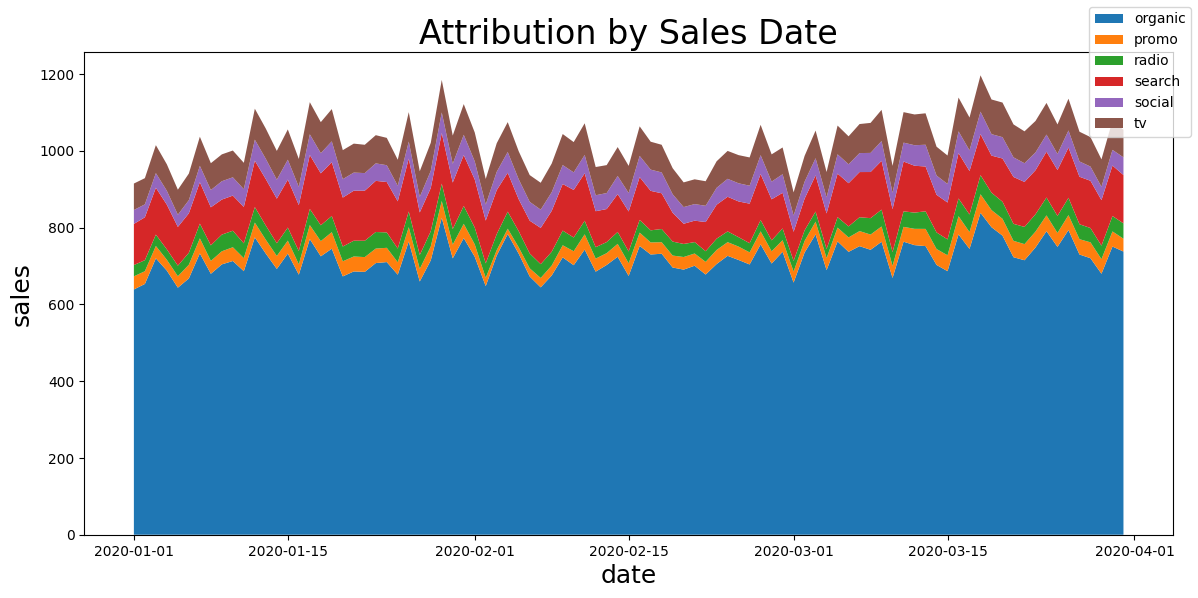

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.stackplot(
    activities_attr_df["date"].values,
    activities_attr_df[channels].values.transpose(),
    labels=channels,
)
ax.set_title("Attribution by Sales Date", fontdict={"fontsize": 24})
ax.set_xlabel("date", fontdict={"fontsize": 18})
ax.set_ylabel("sales", fontdict={"fontsize": 18})
fig.legend()
fig.tight_layout()

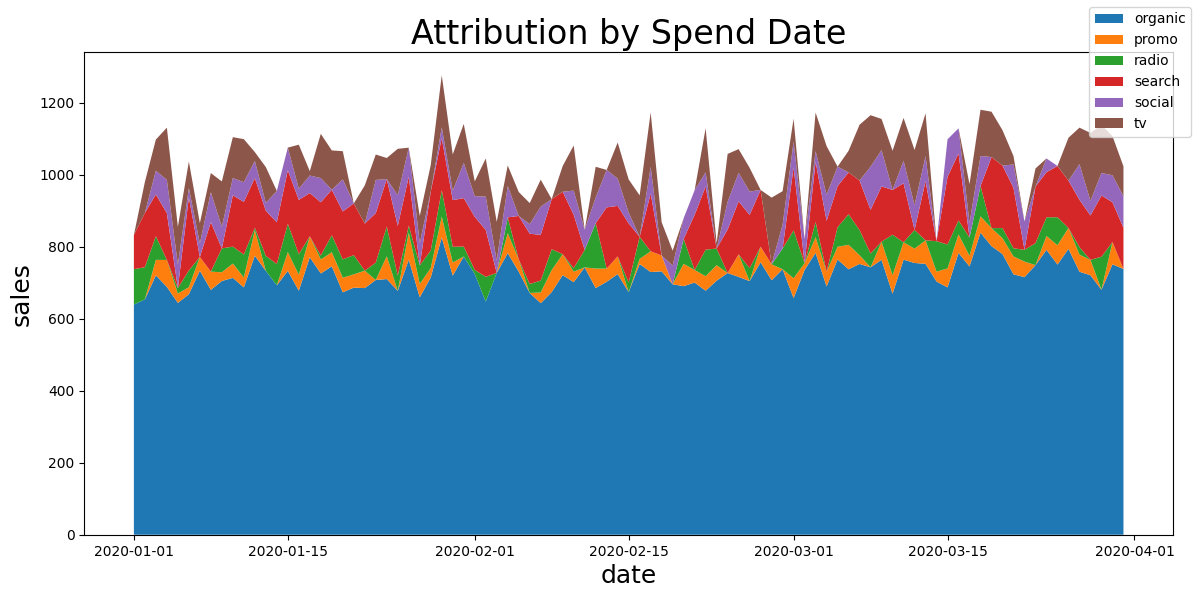

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.stackplot(
    spend_attr_df["date"].values,
    spend_attr_df[channels].values.transpose(),
    labels=channels,
)
ax.set_title("Attribution by Spend Date", fontdict={"fontsize": 24})
ax.set_xlabel("date", fontdict={"fontsize": 18})
ax.set_ylabel("sales", fontdict={"fontsize": 18})
fig.legend()
fig.tight_layout()

### Attribution on Future Performance with Model Prediction

Users can also use attribution on future predictions from the model. This simply means making attribution on predicted response since the actual response has not been observed yet. The first step is to create the data frame contains future information needed to make prediction. The package offers a utilities to make future features by rolling mean.

In [9]:
from karpiu.utils import extend_ts_features

N_PERIODS = 180
df = mmm.get_raw_df()
extended_df = df[["date"] + spend_cols]
extended_df = extend_ts_features(
    extended_df, n_periods=N_PERIODS, date_col="date", rolling_window=30
)
extended_df.tail(10)

,date,promo,radio,search,social,tv
1237,2022-05-22,1816.00000,3874.50000,3509.50000,2693.00000,5694.50000
1238,2022-05-23,1816.00000,3874.50000,3509.50000,2693.00000,5694.50000
1239,2022-05-24,1816.00000,3874.50000,3509.50000,2693.00000,5694.50000
1240,2022-05-25,1816.00000,3874.50000,3509.50000,2693.00000,5694.50000
1241,2022-05-26,1816.00000,3874.50000,3509.50000,2693.00000,5694.50000
1242,2022-05-27,1816.00000,3874.50000,3509.50000,2693.00000,5694.50000
1243,2022-05-28,1816.00000,3874.50000,3509.50000,2693.00000,5694.50000
1244,2022-05-29,1816.00000,3874.50000,3509.50000,2693.00000,5694.50000
1245,2022-05-30,1816.00000,3874.50000,3509.50000,2693.00000,5694.50000
1246,2022-05-31,1816.00000,3874.50000,3509.50000,2693.00000,5694.50000


Then the next step is to make prediction and relabel it as the response column.

In [10]:
pred_df = mmm.predict(extended_df)
expected_sales = np.concatenate(
    [df["sales"].values, pred_df["prediction"].values[-N_PERIODS:]]
)
extended_df["sales"] = expected_sales

With the extended dataframe, users can input it into the Attributor as external data and follow the previous syntax to make attribution.

In [11]:
ATTR_START = "2022-01-01"
ATTR_END = "2022-04-30"

attr_obj = Attributor(mmm, start=ATTR_START, end=ATTR_END, df=extended_df)
activities_attr_df, spend_attr_df, spend_df, cost_df = attr_obj.make_attribution()

In [8]:
spend_attr_df.tail(10)

,date,organic,promo,radio,search,social,tv
21,2020-01-22,839.62983,0.00000,0.01199,160.29584,148.06549,82.99685
22,2020-01-23,801.63806,0.00588,0.00000,119.67942,57.65970,105.01694
23,2020-01-24,884.25615,0.00583,0.01042,139.70150,0.00000,56.02611
24,2020-01-25,769.14114,0.00460,0.00527,0.00000,80.90229,52.94669
25,2020-01-26,849.81709,0.00408,0.00000,139.98358,125.21923,34.97601
26,2020-01-27,798.15971,0.00000,0.00886,134.64560,117.57200,62.61383
27,2020-01-28,889.29907,0.00575,0.01286,125.68232,0.00000,0.00000
28,2020-01-29,836.43117,0.00000,0.01634,0.00000,102.31789,62.23460
29,2020-01-30,926.26813,0.00629,0.01722,178.74394,101.85263,113.11179
30,2020-01-31,808.23866,0.00472,0.00000,125.88126,0.00000,40.87536


### Debug

In [4]:
import pytest
import numpy as np
import pandas as pd

from karpiu.models import MMM
from karpiu.simulation import make_mmm_daily_data
from karpiu.explainability.attribution import Attributor

with_events = False
seasonality = [365.25]
fs_orders = [3]

# data_args
seed = 2022
n_steps = 365 * 3
channels_coef = [0.053, 0.08, 0.19, 0.125, 0.1]
channels = ["promo", "radio", "search", "social", "tv"]
features_loc = np.array([2000, 5000, 3850, 3000, 7500])
features_scale = np.array([550, 2500, 500, 1000, 3500])
scalability = np.array([3.0, 1.25, 0.8, 1.3, 1.5])
start_date = "2019-01-01"
best_params = {
    "damped_factor": 0.9057,
    "level_sm_input": 0.0245,
}
adstock_args = {
    "n_steps": 28,
    "peak_step": np.array([10, 8, 5, 3, 2]),
    "left_growth": np.array([0.05, 0.08, 0.1, 0.5, 0.75]),
    "right_growth": np.array([-0.03, -0.6, -0.5, -0.1, -0.25]),
}

np.random.seed(seed)
with_yearly_seasonality = False
if seasonality is not None and len(seasonality) > 0:
    with_yearly_seasonality = True

df, scalability_df, adstock_df, event_cols = make_mmm_daily_data(
    channels_coef=channels_coef,
    channels=channels,
    features_loc=features_loc,
    features_scale=features_scale,
    scalability=scalability,
    n_steps=n_steps,
    start_date=start_date,
    adstock_args=adstock_args,
    with_yearly_seasonality=with_yearly_seasonality,
    country="US" if with_events else None,
)
mmm = MMM(
    kpi_col="sales",
    date_col="date",
    spend_cols=channels,
    event_cols=event_cols,
    seasonality=seasonality,
    fs_orders=fs_orders,
    adstock_df=adstock_df,
    seed=seed,
)
mmm.derive_saturation(df=df, scalability_df=scalability_df)
mmm.set_hyper_params(best_params)
mmm.fit(df, num_warmup=100, num_sample=100, chains=4)

channels_subsets = (channels, channels[0:2])

attr_start = "2020-01-01"
attr_end = "2020-01-31"
duration = (pd.to_datetime(attr_end) - pd.to_datetime(attr_start)).days + 1

for ch_subset in channels_subsets:
    attr_obj = Attributor(
        mmm,
        attr_regressors=ch_subset,
        start=attr_start,
        end=attr_end,
    )

    res = attr_obj.make_attribution(debug=True)
    delta_matrix = attr_obj.delta_matrix

    # after the adstock period, all delta should be finite
    assert np.all(delta_matrix[mmm.get_max_adstock() :, ...] >= 0.0)
    activities_attr_df, spend_attr_df, spend_df, cost_df = res

    assert activities_attr_df.shape[0] == duration
    assert (activities_attr_df.shape[1] - 2) == len(ch_subset)
    assert spend_attr_df.shape[0] == duration
    assert (spend_attr_df.shape[1] - 2) == len(ch_subset)
    assert cost_df.shape[0] == duration

# test different ways to call attribution
# TODO: parameterize this later
# with regressors specified
attr_obj = Attributor(
    mmm,
    attr_regressors=channels[0:2],
    start="2020-01-01",
    end="2020-01-31",
)
_, _, _, _ = attr_obj.make_attribution()
# without regressors specified
attr_obj = Attributor(
    mmm,
    start="2020-01-01",
    end="2020-01-31",
)
# with regressors specified
attr_obj = Attributor(
    mmm,
    attr_regressors=channels[0:2],
    start="2020-01-01",
    end="2020-01-31",
)
_, _, _, _ = attr_obj.make_attribution()
# without date-range specified
attr_obj = Attributor(
    mmm,
)
_, _, _, _ = attr_obj.make_attribution()
# with df specified
attr_obj = Attributor(
    mmm,
    df=mmm.get_raw_df(),
    start="2020-01-01",
    end="2020-01-31",
)
_, _, _, _ = attr_obj.make_attribution()

2023-03-20 20:48:57 - karpiu-mmm - INFO - Initialize model
2023-03-20 20:48:57 - karpiu-mmm - INFO - Deriving saturation constants...
2023-03-20 20:48:57 - karpiu-mmm - INFO - Derived saturation constants.
2023-03-20 20:48:57 - karpiu-mmm - INFO - Set hyper-parameters.
2023-03-20 20:48:57 - karpiu-mmm - INFO - Best params damped_factor set as 0.90570
2023-03-20 20:48:57 - karpiu-mmm - INFO - Best params level_sm_input set as 0.02450
2023-03-20 20:48:57 - karpiu-mmm - INFO - Fit final model.
2023-03-20 20:48:57 - karpiu-mmm - INFO - Build a default regression scheme
2023-03-20 20:48:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 25 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-03-20 20:49:02 - karpiu-mmm - INFO - Spend channels regression coefficients sum (0.277449967) is within common range (0, 0.8].


I'm here.
(139,)
(139,)
I'm here.
(139,)
(139,)


AssertionError: 

In [5]:
mmm.get_max_adstock()

27

In [6]:
mmm.get_max_adstock() * 4 + 31

139

In [17]:
# test different ways to call attribution
# TODO: parameterize this later
# with regressors specified
attr_obj = Attributor(
    mmm,
    attr_regressors=channels[0:2],
    start="2020-01-01",
    end="2020-01-31",
)
_, _, _, _ = attr_obj.make_attribution()
# without regressors specified
attr_obj = Attributor(
    mmm,
    start="2020-01-01",
    end="2020-01-31",
)
# with regressors specified
attr_obj = Attributor(
    mmm,
    attr_regressors=channels[0:2],
    start="2020-01-01",
    end="2020-01-31",
)
_, _, _, _ = attr_obj.make_attribution()
# without date-range specified
attr_obj = Attributor(
    mmm,
)
_, _, _, _ = attr_obj.make_attribution()
# with df specified
attr_obj = Attributor(
    mmm,
    df=mmm.get_raw_df(),
    start="2020-01-01",
    end="2020-01-31",
)
_, _, _, _ = attr_obj.make_attribution()

In [13]:
mmm.get_max_adstock()

27

In [11]:
delta_matrix.shape

(58, 28, 6)

In [14]:
for ch_subset in channels_subsets:
    attr_obj = Attributor(
        mmm,
        attr_regressors=ch_subset,
        start="2020-01-01",
        end="2020-01-31",
    )

    res = attr_obj.make_attribution(debug=True)
    activities_attr_df, spend_attr_df, spend_df, cost_df = res

    assert activities_attr_df.shape[0] == duration
    assert (activities_attr_df.shape[1] - 2) == len(ch_subset)
    assert spend_attr_df.shape[0] == duration
    assert (spend_attr_df.shape[1] - 2) == len(ch_subset)
    assert cost_df.shape[0] == duration

    # in no adstock case, activities and spend attribution should be identical
    assert np.all(
        np.equal(
            activities_attr_df[["organic"] + ch_subset].values,
            spend_attr_df[["organic"] + ch_subset].values,
        )
    )

AssertionError: 

In [6]:
# in single step, compare with prediction delta to make sure the one-of is calculated
# correctly
attr_obj = Attributor(
    mmm,
    attr_regressors=channels,
    start=attr_start,
    end=attr_end,
)
# extract delta matrix
res = attr_obj.make_attribution(debug=True)
activities_attr_df, spend_attr_df, spend_df, cost_df = res
delta_matrix = attr_obj.delta_matrix

assert np.all(delta_matrix >= 0.0)

# prediction delta
full_pred = mmm.predict(df)
full_comp = full_pred.loc[full_pred["date"] == "2020-01-01", "prediction"].values

pred_delta = np.zeros(len(channels) + 1)
all_off_df = df.copy()
all_off_df.loc[all_off_df["date"] == "2020-01-01", channels] = 0.0
all_off_pred = mmm.predict(all_off_df)
all_off_comp = all_off_pred.loc[
    all_off_pred["date"] == "2020-01-01", "prediction"
].values
pred_delta[0] = all_off_comp
for idx, ch in enumerate(channels):
    one_off_df = df.copy()
    one_off_df.loc[one_off_df["date"] == "2020-01-01", ch] = 0.0
    one_off_pred = mmm.predict(one_off_df)
    one_off_comp = one_off_pred.loc[
        one_off_pred["date"] == "2020-01-01", "prediction"
    ].values
    pred_delta[idx + 1] = full_comp - one_off_comp

assert np.allclose(delta_matrix[0, 0, ...], pred_delta)